In [2]:
!pip install ucimlrepo pyinform

# TODO

- two methods using information theory measures (your own implementation incorporating discretization of continuous predictors)
    - a criterion which weights relevancy and redundancy such as JMI or SECMI
        - https://www.jmlr.org/papers/volume22/19-600/19-600.pdf
        - https://www.jmlr.org/papers/volume13/brown12a/brown12a.pdf
    - a mini-max criterion as proposed e.g. by
        - https://www.jmlr.org/papers/volume5/fleuret04a/fleuret04a.pdf
        - https://papers.nips.cc/paper_files/paper/2016/file/d5e2fbef30a4eb668a203060ec8e5eef-Paper.pdf

- two arbitrary methods, which may include wrapper methods like Lasso regularization, decision tree-based feature importance or wrapper methods like recursive feature elimination.

At least two artificial examples (at least one from each bullet point) and three real-world data examples must be provided:
1. an artificial example, for which the set of significant features is known (comparing feature selection methods and checking the performance of a stopping rule)
2. an artificial example in which one of the MI-based methods doesn’t work
3. examples using e.g. dataset from UCI. The effectiveness of the feature selection methods can be evaluated by fitting a generic classification model and measuring its performance (see Brown et al).

# Imports



In [43]:
import os
import copy
import logging
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import tqdm

from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score

from ucimlrepo import fetch_ucirepo

from pyinform.dist import Dist
from pyinform import shannon

logger = logging.getLogger('MatUnder')

# Dataset

In [24]:
def histogram_args(x):
    xmin, xmax = x.min(), x.max()
    if np.issubdtype(x.dtype, np.floating):
        iqr = max(np.subtract(*np.percentile(x, [75, 25])), 1e-2)
        bin_width = 2 * iqr * np.power(x.shape[0], -1/3)
        # print(bin_width, iqr)
        # if bin_width < 1e-3:
        #     return None, [xmin, xmax]
        bins = max(int(np.ceil((xmax - xmin) / bin_width)),1)
        return min(bins, 1000), [xmin, xmax]
    return np.unique(x).shape[0], [xmin, xmax]


class Dataset:
    def __repr__(self):
        name=self.name
        features = len(self.features)
        target = self.target
        samples = len(self.data)
        return f"{self.__class__.__name__}({name=!r} {target=!r} {features=} {samples=})"

    def train_test_split(self, test_size=0.2):
        train, test = train_test_split(np.arange(len(self.data)), test_size=test_size)
        return self.sample(train), self.sample(test)

    def sample(self, indices=None, **kwargs):
        return self.__class__(
            data=self.data.loc[indices] if indices is not None else self.data.sample(**kwargs),
            features=self.features,
            target=self.target,
            name=self.name,
            orig=self.orig.loc[indices] if indices is not None else None
        )

    def get_Xy(self, orig=False):
        if orig:
            return self.orig[self.features], self.orig[self.target]
        return self.data[self.features], self.data[self.target]

    @classmethod
    def from_uci(cls, id: int):
        repo = fetch_ucirepo(id=id);
        [target] = repo.variables.query("role == 'Target'").name.tolist()
        return cls(
            data=pd.concat([repo.data.features, repo.data.targets], axis=1),
            features=repo.variables.query("role == 'Feature'").name.tolist(),
            target=target,
            name=repo.metadata.name
        )

    def __init__(
        self,
        data: pd.DataFrame,
        features: list[str],
        target: str,
        name: str = 'Dataset',
        orig=None
    ):
        self.orig = data if orig is None else orig
        self.data = {} if orig is None else data
        self.dists = {}
        self.features = features
        self.target = target
        self.name = name
        if target in features:
            raise ValueError

        if orig is not None:
            return

        for name in features:
            x = data[name]
            counts, bins = None, None
            if np.issubdtype(x.dtype, np.floating):
                # try:
                counts, bins = np.histogram(x, *histogram_args(x))
                # except Exception as e:
                #     print(e, name)
                # if counts is not None:
                x = np.digitize(x, bins)
                # else:
                #     _, counts = np.unique(x, return_counts=True)
            else:
                if not np.issubdtype(x.dtype, np.integer):
                    x = LabelEncoder().fit_transform(x)
                _, counts = np.unique(x, return_counts=True)
            self.dists[name,] = Dist(counts)
            self.data[name] = x

        self.data = pd.DataFrame(self.data)
        self.data[self.target] = LabelEncoder().fit_transform(data[self.target])
        self.dists[self.target,] = Dist(
            np.unique(self.data[self.target], return_counts=True)[1]
        )

    def get_dist(self, *names):
        names = tuple(sorted(names))
        if names in self.dists:
            return self.dists[names]
        _, counts = np.unique(
            self.data[[*names]].values, axis=0, return_counts=True
        )
        return Dist(counts)

# Information Theory methods

In [30]:
def mutual_info(ds: Dataset, x: str, y: str):
    return shannon.mutual_info(
        p_xy=ds.get_dist(x, y),
        p_x=ds.get_dist(x),
        p_y=ds.get_dist(y),
    )


def conditional_mutual_info(ds: Dataset, x: str, y: str, z: str):
    return shannon.conditional_mutual_info(
        p_xyz=ds.get_dist(x, y, z),
        p_xz=ds.get_dist(x, z),
        p_yz=ds.get_dist(y, z),
        p_z=ds.get_dist(z),
    )


def joint_mutual_info(ds: Dataset, k: str, S: list[str] | set[str], y: str):
    return sum(
        mutual_info(ds, j, y) + conditional_mutual_info(ds, k, y, j)
        for j in list(S)
    )


def _grow_features(
    ds, criterion, V, MB, target,
    epsilon: float = 1e-3,
    disable_tqdm: bool = False,
    n_features_to_select: int | None = None
):
    not_changed = 0
    pb = tqdm(
        desc='JMI: growing',
        total=n_features_to_select or len(V - MB),
        disable=disable_tqdm
    )
    while (candidates := list(V - MB)):
        if n_features_to_select and len(MB) == n_features_to_select:
            break
        scores = [
            criterion(ds, k, MB, target) if MB else mutual_info(ds, k, target)
            for k in candidates
        ]
        index = np.argmax(scores)
        score = scores[index]
        k = candidates[index]
        if score > epsilon:
            MB.add(k)
            pb.update(1)
            not_changed = 0
            logger.debug("added feature '%s', mutual info: %f", k, score)
        else:
            V = V - {k}
            pb.update(1)
            not_changed += 1
            logger.info("feature '%s', mutual info: %f < %s", k, score, epsilon)
            # if not_changed > 1:
            #     logger.info("MB is not changing")
            #     break
    pb.close()
    logger.info("finished growing phase")
    return MB


def _shrink_features(
    ds, criterion, V, MB, target,
    epsilon: float = 1e-3,
    disable_tqdm: bool = False, **kwargs
):
    if len(MB) <= 1:
        logger.info("skipping shrinking phase, no features to remove")
        return MB

    scores = {}
    for k in tqdm(list(MB), desc='JMI: shrinking', disable=disable_tqdm):
        score = scores[k] = criterion(ds, k, MB - {k}, target)
        if score <= epsilon:
            MB = MB - {k}
            logger.debug(
                "removed feature '%s', mutual info: %f < %s", k, score, epsilon)
        else:
            logger.debug("feature '%s', mutual info: %f", k, score)
    logger.info("finished shrinking phase")
    return MB, scores


def iamb(ds: Dataset, criterion, **kwargs):
    """http://www.jcomputers.us/vol5/jcp0511-18.pdf"""
    MB = set()
    V = set(ds.features)
    MB = _grow_features(ds, criterion, V, MB, ds.target, **kwargs)
    MB, scores = _shrink_features(ds, criterion, V, MB, ds.target, **kwargs)
    selected_features, scores = zip(*sorted(
        list(scores.items()), key=lambda x: -x[1]
    ))
    return selected_features, scores


def jmi(ds: Dataset, **kwargs):
    return iamb(ds, joint_mutual_info, **kwargs)

#
# https://github.com/atif-hassan/PyImpetus/blob/master/PyImpetus.py


def cmim(
    ds: Dataset,
    n_features_to_select: int | None = None,
    disable_tqdm=False,
    **kwargs
):
    """
    Fast version of CMIM
    from https://www.jmlr.org/papers/volume5/fleuret04a/fleuret04a.pdf
    """
    n_features = len(ds.features)
    is_n_selected_features_specified = bool(n_features_to_select)
    F = np.zeros(n_features, dtype=int) - 1
    ps = np.array([mutual_info(ds, ds.target, f) for f in ds.features])
    m = np.zeros(n_features, dtype=int) - 1

    pb = tqdm(desc='CMIM', total=n_features_to_select or n_features, disable=disable_tqdm)
    for k in range(n_features):
        pb.update(1)
        if k == 0:
            # select the feature whose mutual information is the largest
            F[0] = np.argmax(ps)
            logger.debug(
                "added feature '%s' with maximal MI (%f)",
                ds.features[F[0]], ps[F[0]]
            )

        if n_features_to_select:
            if np.sum(F > -1) == n_features_to_select:
                break

        sstar = -np.inf # start with really low value for best partial score sstar
        for i in range(n_features):
            if i not in F:
                while (ps[i] > sstar) and (m[i]<k-1):
                    m[i] = m[i] + 1
                    ps[i] = min(
                        ps[i],
                        conditional_mutual_info(
                            ds, ds.target, ds.features[i], ds.features[F[m[i]]]
                        )
                    )
                if ps[i] > sstar:
                    sstar = ps[i]
                    F[k+1] = i
        logger.debug(
            "added feature '%s', mutual info: %f",
            ds.features[F[k+1]], sstar
        )

    pb.close()
    F = F[F>-1]
    return [ds.features[i] for i in F], ps[F]

# Estimator-based method

In [29]:
def fit_estimator(ds: Dataset):
    return RandomForestClassifier(random_state=0).fit(*ds.get_Xy())

def estimator_feature_importance(
    ds: Dataset,
    estimator=None,
    n_features_to_select=None,
    **kwargs,
):
    estimator = estimator or fit_estimator(ds)
    importances = estimator.feature_importances_
    std = np.std([tree.feature_importances_ for tree in estimator.estimators_], axis=0)
    idx = np.argsort(-importances)
    for i in idx[:max(len(idx)//10, 10)]:
        logger.debug(
            "feature '%s': importance %f, std %f",
            ds.features[i], importances[i], std[i]
        )
    if n_features_to_select:
        idx = idx[:n_features_to_select]
    return [ds.features[i] for i in idx], importances[idx]


def recursive_feature_elimination(
    ds: Dataset, estimator=None,
    n_features_to_select=None,
    step=1,
    **kwargs,
):
    estimator = estimator or fit_estimator(ds)
    selector = RFE(
        estimator, n_features_to_select=n_features_to_select, step=step
    )
    selector = selector.fit(*ds.get_Xy())
    features = [
        f for f, selected in zip(ds.features, selector.support_)
        if selected
    ]
    ranking = selector.ranking_[selector.support_]
    idx = np.argsort(ranking)
    return [features[i] for i in idx], ranking[idx]

def estimator_permutation_importance(
    ds: Dataset, estimator=None,
    n_features_to_select=None,
    n_repeats=5,
    **kwargs,
):
    estimator = estimator or fit_estimator(ds)
    result = permutation_importance(
        estimator, *ds.get_Xy(), n_repeats=n_repeats, random_state=0
    )
    idx = np.argsort(-result.importances_mean)
    if n_features_to_select:
        idx = idx[:n_features_to_select]
    return [ds.features[i] for i in idx], result.importances_mean[idx]



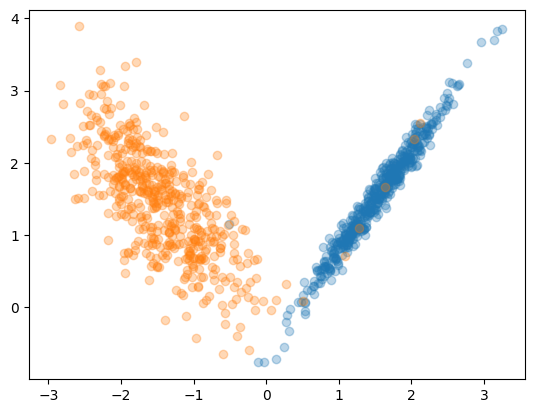

In [10]:
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_clusters_per_class=1,
    flip_y=0.01,
    class_sep=1.5,
    hypercube=True,
    shift=0.0,
    scale=1.0,
    shuffle=True,
    random_state=None
)
plt.scatter(X[y==0, 0], X[y==0, 1], alpha=0.3)
plt.scatter(X[y==1, 0], X[y==1, 1], alpha=0.3)
plt.show()

In [11]:
def make_classification_dataset(
    n_informative=20,
    n_redundant=480,
    n_repeated=0,
    **kwargs
):
    n_features = n_informative + n_redundant + n_repeated
    features = (
        [f'inf_{i}' for i in range(n_informative)] +
        [f'red_{i}' for i in range(n_redundant)] +
        [f'rep_{i}' for i in range(n_repeated)]
    )
    X, y = make_classification(
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_features=n_features,
        n_repeated=n_repeated,
        **kwargs
    )
    data = pd.DataFrame(X, columns=features)
    data['label'] = y
    return Dataset(
        data=data,
        features=features,
        target='label',
        name=f'artificial({n_informative=} {n_redundant=} {n_repeated=})'

    )


# Experiments

In [32]:
def run_experiments(
    ds,
    n_features_to_select=None, sample=None, methods=None, n_trials=1, tqdm_disable=True
):
    methods = methods or [jmi, cmim, estimator_feature_importance,
                          estimator_permutation_importance]
    results = []
    for feature_selection in methods:
        for i in tqdm(range(n_trials), desc=feature_selection.__name__):
            ds_ = ds if isinstance(ds, Dataset) else ds()
            features, scores = feature_selection(
                ds=(ds_.sample(n=sample) if sample else ds_),
                n_features_to_select=n_features_to_select,
                disable_tqdm=tqdm_disable,
            )
            trial_result = {
                'method': feature_selection.__name__,
                'trial': i,
                'features': list(features),
                'scores': list(scores),
            }
            if ds_.name.startswith('artificial'):
                trial_result['n_selected_probes'] = len([
                    f for f in features if not f.startswith('inf_')
                ])
            results.append(trial_result)
    return pd.DataFrame(results)

def plot_features_selected(df, groups=None, row_index='index', width=0.05, figsize=(20, 5)):
    groups = groups or ['cmim', 'jmi', 'estimator_feature_importance', 'estimator_permutation_importance']
    counts = {
        row[row_index]: [row[f] for f in groups]
        for row in df.reset_index().to_dict('records')
    }

    x = np.arange(len(groups))
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=figsize)

    for attribute, measurement in counts.items():
        offset = width * multiplier
        rects = ax.bar(
            x + offset, measurement, width, label=attribute,
            color=dict(inf='green', red='red', rep='blue')[attribute[:3]]
        )
        ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_xticks(x + width, groups)
    plt.show()

def count_features(ds, df):
    ds = ds if isinstance(ds, Dataset) else ds()
    counts = []
    for trial in df.to_dict('records'):
        selections = {f: f in trial['features'] for f in ds.features}
        selections['method'] = trial['method']
        counts.append(selections)
    return pd.DataFrame(counts).groupby('method').sum()

In [15]:
def make_easy_dataset(n_samples, n_informative, n_redundant=0, sparse=0, y_flip=0):
    n_features = n_informative + n_redundant
    features = (
        [f'inf_{i}' for i in range(n_informative)] +
        [f'red_{i}' for i in range(n_redundant)]
    )
    X_relevant = np.random.normal(0, 1, (n_samples, n_informative))
    for i in range(n_informative):
        X_relevant[np.random.choice(np.arange(n_samples), int(n_samples*sparse)), i] = 1e-3
    for i in range(n_redundant):
        X_relevant[np.random.choice(np.arange(n_samples), int(n_samples*sparse)), i] = 1e-3
    X_irrelevant = np.random.normal(0, 1, (n_samples, n_redundant))
    X = np.hstack((X_relevant, X_irrelevant))
    y = np.sum(X_relevant, axis=1)
    y = y > n_informative
    to_flip = np.random.choice(np.arange(n_samples), int(n_samples*y_flip))
    y[to_flip] = ~y[to_flip]
    data = pd.DataFrame(X, columns=features)
    data['y'] = y.astype(int)
    return Dataset(
        data=data,
        features=features,
        target='y',
        name=f'artificial({n_informative=} {n_redundant=})'

    )

artificial_easy = partial(
    make_easy_dataset, n_samples=500, n_informative=4, n_redundant=4, y_flip=0.02, sparse=0.3
)
result_easy = run_experiments(artificial_easy, n_features_to_select=4, n_trials=50)
result_easy.groupby('method').n_selected_probes.mean().sort_values()

jmi:   0%|          | 0/50 [00:00<?, ?it/s]

cmim:   0%|          | 0/50 [00:00<?, ?it/s]

estimator_feature_importance:   0%|          | 0/50 [00:00<?, ?it/s]

estimator_permutation_importance:   0%|          | 0/50 [00:00<?, ?it/s]

method
cmim                                0.04
jmi                                 1.20
estimator_feature_importance        1.24
estimator_permutation_importance    2.22
Name: n_selected_probes, dtype: float64

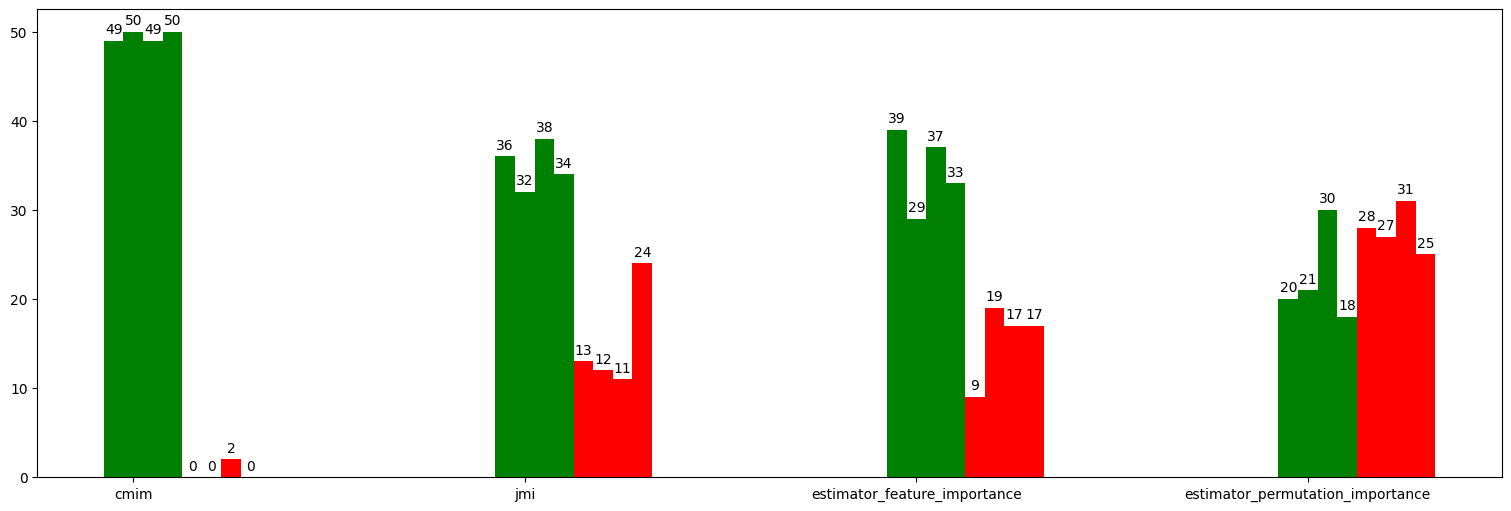

In [16]:
counts_easy = count_features(artificial_easy, result_easy)
plot_features_selected(counts_easy.T.reset_index(), figsize=(15, 5))

In [17]:
artificial_easy = partial(
    make_easy_dataset, n_samples=500, n_informative=4, n_redundant=4, y_flip=0.02, sparse=0.01
)
result_easy = run_experiments(artificial_easy, n_features_to_select=4, n_trials=50)
result_easy.groupby('method').n_selected_probes.mean().sort_values()

jmi:   0%|          | 0/50 [00:00<?, ?it/s]

cmim:   0%|          | 0/50 [00:00<?, ?it/s]

estimator_feature_importance:   0%|          | 0/50 [00:00<?, ?it/s]

estimator_permutation_importance:   0%|          | 0/50 [00:00<?, ?it/s]

method
estimator_feature_importance        0.50
estimator_permutation_importance    0.52
jmi                                 0.78
cmim                                0.98
Name: n_selected_probes, dtype: float64

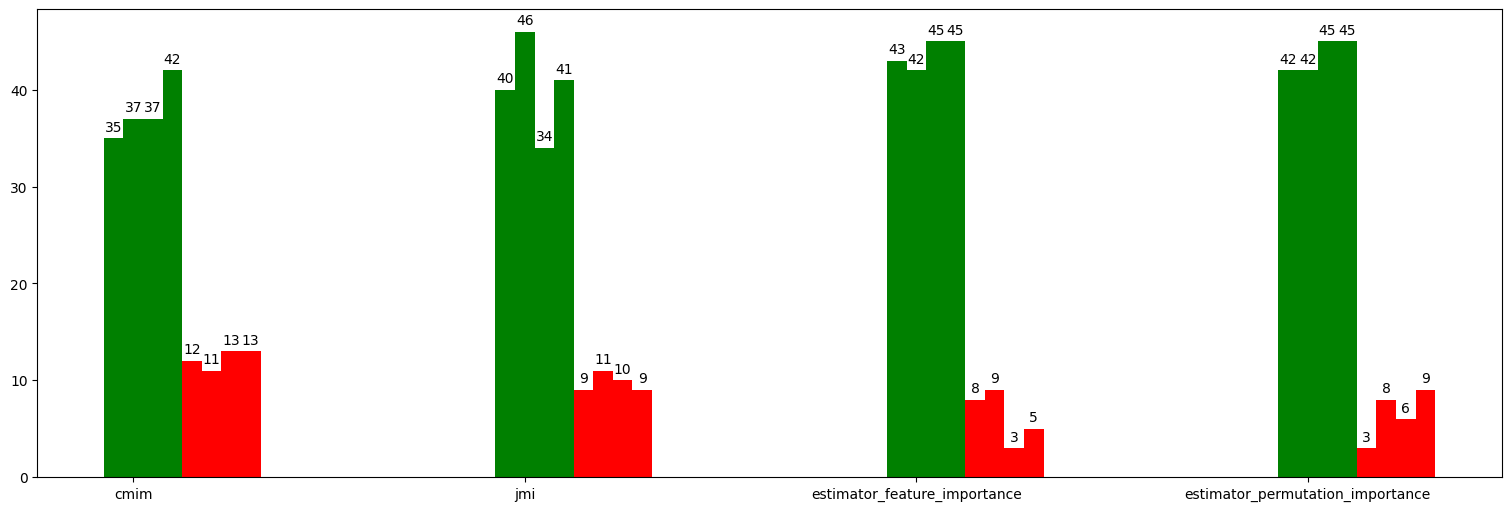

In [18]:
counts_easy = count_features(artificial_easy, result_easy)
plot_features_selected(counts_easy.T.reset_index(), figsize=(15, 5))

In [144]:
def make_classifier(in_features, hidden_state=500):
    return nn.Sequential(
        nn.Linear(in_features, hidden_state),
        nn.ReLU(),
        nn.Linear(hidden_state, hidden_state),
        nn.ReLU(),
        nn.Linear(hidden_state, 1),
        nn.Sigmoid()
    )

def model_train(
        model, X_train, y_train, X_val, y_val,
        n_epochs = 250 ,
        batch_size = 10,
        f1=False
        ):
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    batch_start = torch.arange(0, len(X_train), batch_size)
    best_acc = -np.inf
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        model.eval()
        with torch.no_grad():
            y_pred = model(X_val)
        if f1:
            acc = f1_score(y_val.numpy(), y_pred.round().numpy())
        else:
            acc = (y_pred.round() == y_val).float().mean()
            acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_weights)
    return best_acc

In [138]:
repo = fetch_ucirepo(id=75);
[target] = repo.variables.query("role == 'Target'").name.tolist()
data = pd.concat([repo.data.features, repo.data.targets], axis=1)
integer_columns = data.dtypes[data.dtypes == np.int64].index.tolist()
data[integer_columns] = data[integer_columns].astype(float)
musk = Dataset(
    data=data,
    features=repo.variables.query("role == 'Feature' & name != 'ID'").name.tolist(),
    target=target,
    name=repo.metadata.name
)

In [139]:
train, valid = musk.train_test_split()
X_train = train.orig[train.features]
y_train = train.data[train.target].values
X_valid = valid.orig[train.features]
y_valid = valid.data[valid.target].values

In [140]:
result_musk = run_experiments(train, n_features_to_select=20, n_trials=1, tqdm_disable=False)

jmi:   0%|          | 0/1 [00:00<?, ?it/s]

JMI: growing:   0%|          | 0/20 [00:00<?, ?it/s]

JMI: shrinking:   0%|          | 0/20 [00:00<?, ?it/s]

cmim:   0%|          | 0/1 [00:00<?, ?it/s]

CMIM:   0%|          | 0/20 [00:00<?, ?it/s]

estimator_feature_importance:   0%|          | 0/1 [00:00<?, ?it/s]

estimator_permutation_importance:   0%|          | 0/1 [00:00<?, ?it/s]

In [145]:
nn_result_musk = []
for _, row in result_musk.iterrows():
    for k in range(5, len(row.features)+1, 5):
        print(k, row.method)
        model = make_classifier(k)
        acc = model_train(
            model,
            torch.tensor(X_train[row.features[:k]].values.astype(np.float32)),
            torch.tensor(y_train.astype(np.float32)).view(-1, 1),
            torch.tensor(X_valid[row.features[:k]].values.astype(np.float32)),
            torch.tensor(y_valid.astype(np.float32)).view(-1, 1),
            n_epochs=3,
            batch_size=128
        )
        nn_result_musk.append(
            {
                'method': row.method,
                'k': k,
                'acc': acc
            }
        )
nn_result_musk = pd.DataFrame(nn_result_musk)
nn_result_musk

5 jmi
10 jmi
15 jmi
20 jmi
5 cmim
10 cmim
15 cmim
20 cmim
5 estimator_feature_importance
10 estimator_feature_importance
15 estimator_feature_importance
20 estimator_feature_importance
5 estimator_permutation_importance
10 estimator_permutation_importance
15 estimator_permutation_importance
20 estimator_permutation_importance


method   k       acc
0                                jmi   5  0.895455
1                                jmi  10  0.920455
2                                jmi  15  0.922727
3                                jmi  20  0.928030
4                               cmim   5  0.896212
5                               cmim  10  0.911364
6                               cmim  15  0.920455
7                               cmim  20  0.926515
8       estimator_feature_importance   5  0.890152
9       estimator_feature_importance  10  0.907576
10      estimator_feature_importance  15  0.925758
11      estimator_feature_importance  20  0.937121
12  estimator_permutation_importance   5  0.862121
13  estimator_permutation_importance  10  0.878788
14  estimator_permutation_importance  15  0.891667
15  estimator_permutation_importance  20  0.925758

In [152]:
def plot_features_accs(df, groups=None, row_index='k', width=0.2, figsize=(13, 5)):
    groups = groups or ['cmim', 'jmi', 'estimator_feature_importance', 'estimator_permutation_importance']
    counts = {
        row[row_index]: [row[f] for f in groups]
        for row in df.reset_index().to_dict('records')
    }

    x = np.arange(len(groups))
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=figsize)
    cmap = plt.get_cmap("viridis")

    for attribute, measurement in counts.items():
        offset = width * multiplier
        rects = ax.bar(
            x + offset, measurement, width, label=f'top {attribute}',
            color=cmap.colors[(attribute - 5)*10]
        )
        ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_xticks(x + width, groups)

    plt.legend(loc='center')
    plt.show()

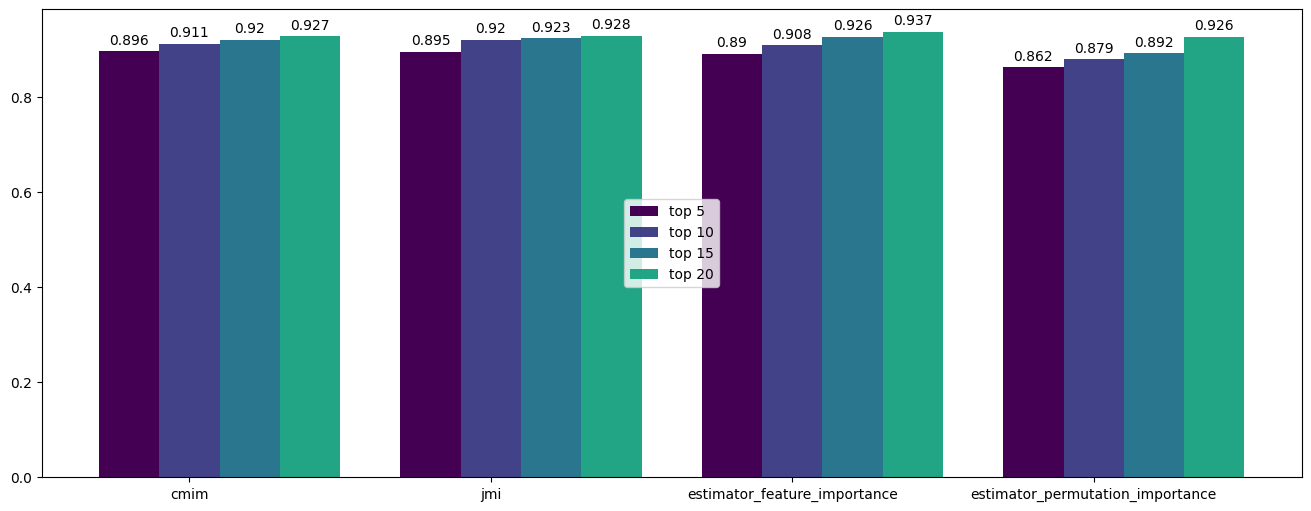

In [159]:
plot_features_accs(nn_result_musk.pivot(columns='k', values='acc', index='method').round(3).T)

In [161]:
repo = fetch_ucirepo(id=17);
[target] = repo.variables.query("role == 'Target'").name.tolist()
data = pd.concat([repo.data.features, repo.data.targets], axis=1)
# integer_columns = data.dtypes[data.dtypes == np.int64].index.tolist()
# data[integer_columns] = data[integer_columns].astype(float)
with_nans = [] #data.dtypes[data.dtypes == np.object_].index.tolist()
cancer = Dataset(
    data=data,
    features=repo.variables.query("role == 'Feature' & name != 'ID' & ~name.isin(@with_nans)").name.tolist(),
    target=target,
    name=repo.metadata.name
)
cancer

Dataset(name='Breast Cancer Wisconsin (Diagnostic)' target='Diagnosis' features=30 samples=569)

In [162]:
train, valid = cancer.train_test_split()
X_train = train.orig[train.features]
y_train = train.data[train.target].values
X_valid = valid.orig[train.features]
y_valid = valid.data[valid.target].values

In [163]:
result_cancer = run_experiments(train, n_features_to_select=20, n_trials=1, tqdm_disable=False)

jmi:   0%|          | 0/1 [00:00<?, ?it/s]

JMI: growing:   0%|          | 0/20 [00:00<?, ?it/s]

JMI: shrinking:   0%|          | 0/20 [00:00<?, ?it/s]

cmim:   0%|          | 0/1 [00:00<?, ?it/s]

CMIM:   0%|          | 0/20 [00:00<?, ?it/s]

estimator_feature_importance:   0%|          | 0/1 [00:00<?, ?it/s]

estimator_permutation_importance:   0%|          | 0/1 [00:00<?, ?it/s]

In [164]:
nn_result_cancer = []
for _, row in result_cancer.iterrows():
    for k in range(5, len(row.features)+1, 5):
        print(k, row.method)
        model = make_classifier(k)
        acc = model_train(
            model,
            torch.tensor(X_train[row.features[:k]].values.astype(np.float32)),
            torch.tensor(y_train.astype(np.float32)).view(-1, 1),
            torch.tensor(X_valid[row.features[:k]].values.astype(np.float32)),
            torch.tensor(y_valid.astype(np.float32)).view(-1, 1),
            n_epochs=3,
            batch_size=32,
        )
        nn_result_cancer.append(
            {
                'method': row.method,
                'k': k,
                'acc': acc
            }
        )
nn_result_cancer = pd.DataFrame(nn_result_cancer)
nn_result_cancer

5 jmi
10 jmi
15 jmi
20 jmi
5 cmim
10 cmim
15 cmim
20 cmim
5 estimator_feature_importance
10 estimator_feature_importance
15 estimator_feature_importance
20 estimator_feature_importance
5 estimator_permutation_importance
10 estimator_permutation_importance
15 estimator_permutation_importance
20 estimator_permutation_importance


method   k       acc
0                                jmi   5  0.921053
1                                jmi  10  0.868421
2                                jmi  15  0.938596
3                                jmi  20  0.877193
4                               cmim   5  0.912281
5                               cmim  10  0.850877
6                               cmim  15  0.798246
7                               cmim  20  0.894737
8       estimator_feature_importance   5  0.842105
9       estimator_feature_importance  10  0.842105
10      estimator_feature_importance  15  0.912281
11      estimator_feature_importance  20  0.903509
12  estimator_permutation_importance   5  0.684211
13  estimator_permutation_importance  10  0.798246
14  estimator_permutation_importance  15  0.921053
15  estimator_permutation_importance  20  0.833333

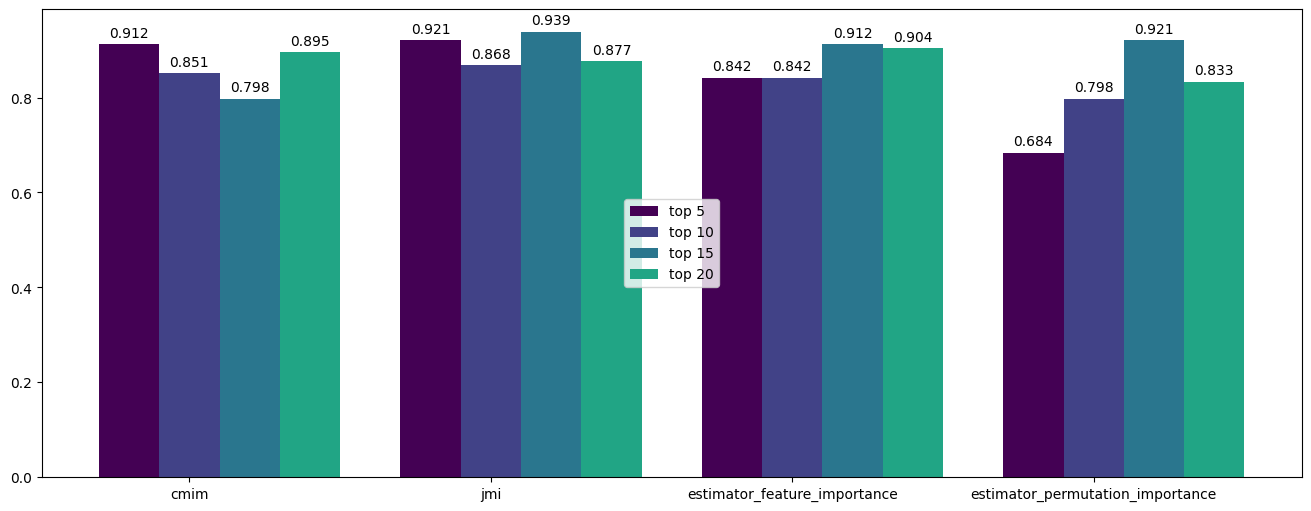

In [165]:
plot_features_accs(nn_result_cancer.pivot(columns='k', values='acc', index='method').round(3).T)

In [166]:
repo = fetch_ucirepo(id=80);
[target] = repo.variables.query("role == 'Target'").name.tolist()
data = pd.concat([repo.data.features, repo.data.targets], axis=1)
# integer_columns = data.dtypes[data.dtypes == np.int64].index.tolist()
# data[integer_columns] = data[integer_columns].astype(float)
with_nans = [] #data.dtypes[data.dtypes == np.object_].index.tolist()
digits = Dataset(
    data=data,
    features=repo.variables.query("role == 'Feature' & name != 'ID' & ~name.isin(@with_nans)").name.tolist(),
    target=target,
    name=repo.metadata.name
)
digits

Dataset(name='Optical Recognition of Handwritten Digits' target='class' features=64 samples=5620)

In [167]:
train, valid = digits.train_test_split()
X_train = train.orig[train.features]
y_train = train.data[train.target].values
X_valid = valid.orig[train.features]
y_valid = valid.data[valid.target].values

In [168]:
result_digits = run_experiments(train, n_features_to_select=20, n_trials=1, tqdm_disable=False)

jmi:   0%|          | 0/1 [00:00<?, ?it/s]

JMI: growing:   0%|          | 0/20 [00:00<?, ?it/s]

JMI: shrinking:   0%|          | 0/20 [00:00<?, ?it/s]

cmim:   0%|          | 0/1 [00:00<?, ?it/s]

CMIM:   0%|          | 0/20 [00:00<?, ?it/s]

estimator_feature_importance:   0%|          | 0/1 [00:00<?, ?it/s]

estimator_permutation_importance:   0%|          | 0/1 [00:00<?, ?it/s]

In [169]:
y_train_1hot = np.zeros([y_train.shape[0], 10])
y_train_1hot[np.arange(y_train.shape[0]), y_train] = 1

y_valid_1hot = np.zeros([y_valid.shape[0], 10])
y_valid_1hot[np.arange(y_valid.shape[0]), y_valid] = 1

In [170]:
def make_mc_classifier(in_features, classes, hidden_state=500):
    return nn.Sequential(
        nn.Linear(in_features, hidden_state),
        nn.ReLU(),
        nn.Linear(hidden_state, hidden_state),
        nn.ReLU(),
        nn.Linear(hidden_state, classes),
        nn.Softmax()
    )

def model_mc_train(
        model, X_train, y_train, X_val, y_val,
        n_epochs = 250 ,
        batch_size = 10,
        ):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    batch_start = torch.arange(0, len(X_train), batch_size)
    best_acc = -np.inf
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch,1)).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        model.eval()
        with torch.no_grad():
            y_pred = model(X_val)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val,1)).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_weights)
    return best_acc

In [171]:
nn_result_digits = []
for _, row in result_digits.iterrows():
    for k in range(5, len(row.features)+1, 5):
        print(k, row.method)
        model = make_mc_classifier(k, 10)
        acc = model_mc_train(
            model,
            torch.tensor(X_train[row.features[:k]].values.astype(np.float32)),
            torch.tensor(y_train_1hot.astype(np.float32)),
            torch.tensor(X_valid[row.features[:k]].values.astype(np.float32)),
            torch.tensor(y_valid_1hot.astype(np.float32)),
            n_epochs=3,
            batch_size=128,
        )
        nn_result_digits.append(
            {
                'method': row.method,
                'k': k,
                'acc': acc
            }
        )
nn_result_digits = pd.DataFrame(nn_result_digits)
nn_result_digits

5 jmi


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


10 jmi


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


15 jmi


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


20 jmi


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


5 cmim


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


10 cmim


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


15 cmim


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


20 cmim


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


5 estimator_feature_importance


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


10 estimator_feature_importance


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


15 estimator_feature_importance


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


20 estimator_feature_importance


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


5 estimator_permutation_importance


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


10 estimator_permutation_importance


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


15 estimator_permutation_importance


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


20 estimator_permutation_importance


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


method   k       acc
0                                jmi   5  0.636121
1                                jmi  10  0.708185
2                                jmi  15  0.914591
3                                jmi  20  0.938612
4                               cmim   5  0.651246
5                               cmim  10  0.785587
6                               cmim  15  0.902135
7                               cmim  20  0.921708
8       estimator_feature_importance   5  0.659253
9       estimator_feature_importance  10  0.725089
10      estimator_feature_importance  15  0.922598
11      estimator_feature_importance  20  0.935943
12  estimator_permutation_importance   5  0.672598
13  estimator_permutation_importance  10  0.884342
14  estimator_permutation_importance  15  0.925267
15  estimator_permutation_importance  20  0.865658

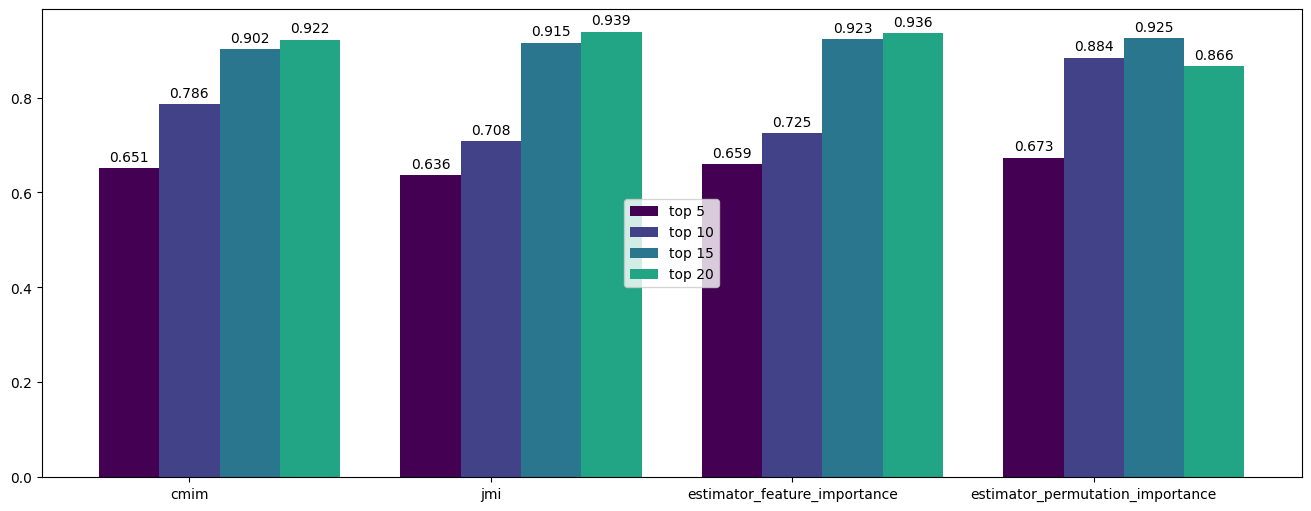

In [172]:
plot_features_accs(nn_result_digits.pivot(columns='k', values='acc', index='method').round(3).T)